# 필요한 라이브러리 호출

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

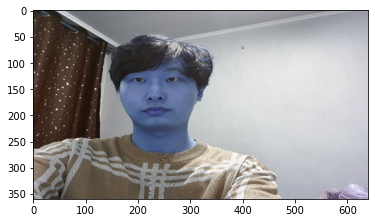

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image5.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

### openCV는 RGB 순서로 이미지 채널을 사용하는게 아니라 예외적으로 BGR(파랑, 녹색, 빨강)을 사용합니다. <br/>그래서 밑에서 RGB이미지로 바꿔줍니다.

# 이미지를 호출해 봅니다.

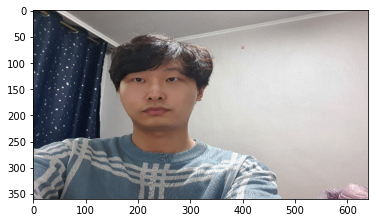

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# detector를 선언합니다.

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

# 비박스를 찾습니다.

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(167, 96) (296, 225)]]


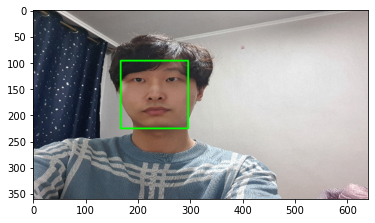

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 랜드마크를 찍기 위해 모델을 불러옵니다.

In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


# 68개의 랜드마크를 찍어 보겠습니다.

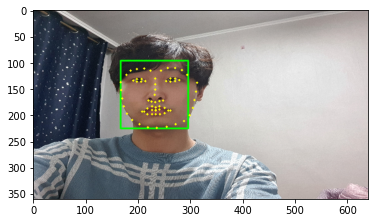

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 이제 이미지의 초기 위치를 설정해야 합니다.

### 저는 힌트에서 준 좌표로 볼을 찾지 않고 입술 중앙 윗부분을 이용해서 고양이 코와 사람 코를 일치 시키려고 합니다.

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[51]) 
    x = landmark[51][0]
    y = landmark[51][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(234, 185)
(x,y) : (234,185)
(w,h) : (130,130)


# 이미지의 크기를 리사이즈 합니다.

In [11]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(130, 130, 3)


# 위에서 설정한 이미지 초기값과 이미지의 높이, 너비를 이용해 코로 이동시켜보겠습니다.

In [12]:
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (169,120)


In [13]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(120, 130, 3)


# 위에서 스티커의 위치를 불러 보았지만 오류는 없었습니다. 하지만 다른 사진은 오류가 생길 수 있어서 짤리는 부분에 대해 오류 수정을 하겠습니다.

In [14]:
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
if refined_y > 360-dlib_rect.width():
    img_sticker = img_sticker[-refined_y:]
    refined_y = 360-dlib_rect.width()
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(120, 130, 3)
(x,y) : (169,120)


# 고양이 수염을 붙여보겠습니다.

In [15]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

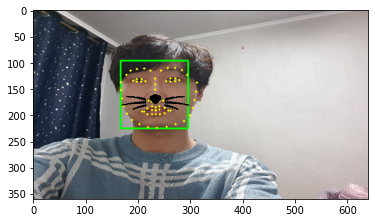

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 비박스와 랜드마크가 없는 이미지를 이용해 수염만 붙여 봅니다.

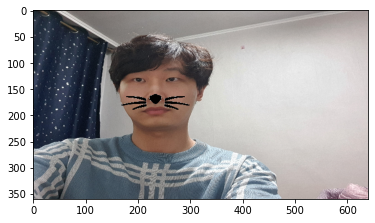

In [17]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 다른 여러가지 사진에 적용 시켜 보겠습니다.

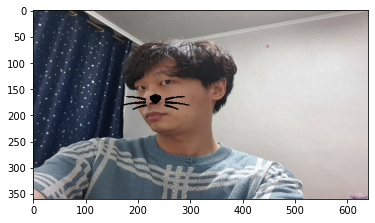

In [18]:
my_image_path_2 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image6.png'
img_bgr_2 = cv2.imread(my_image_path_2)    #- OpenCV로 이미지를 읽어서
img_bgr_2 = cv2.resize(img_bgr_2, (640, 360))    # 640x360의 크기로 Resize
img_show_2 = img_bgr_2.copy()      #- 출력용 이미지 별도 보관

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_2, point, 2, (0, 255, 255), -1) 

img_show_rgb_2 = cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB)

sticker_area = img_bgr_2[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr_2[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_2, cv2.COLOR_BGR2RGB))
plt.show()

# 고개를 살짝 돌려도 어느정도 인식이 됩니다.

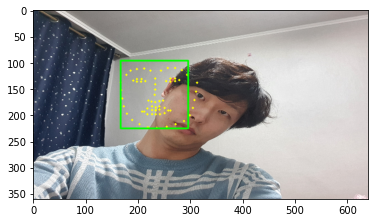

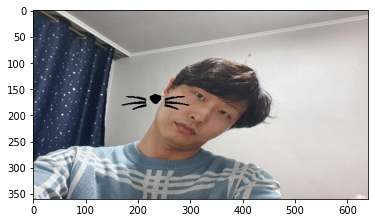

In [19]:
my_image_path_3 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image7.png'
img_bgr_3 = cv2.imread(my_image_path_3)    #- OpenCV로 이미지를 읽어서
img_bgr_3 = cv2.resize(img_bgr_3, (640, 360))    # 640x360의 크기로 Resize
img_show_3 = img_bgr_3.copy()      #- 출력용 이미지 별도 보관

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_3, point, 2, (0, 255, 255), -1) 
        
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_3, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_3 =  cv2.cvtColor(img_show_3, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_3)
plt.show()
img_show_rgb_3 = cv2.cvtColor(img_show_3, cv2.COLOR_BGR2RGB)
        
sticker_area = img_bgr_3[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr_3[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_3, cv2.COLOR_BGR2RGB))
plt.show()

# 고개를 완전히 옆으로 돌리면 비박스가 인식을 하지 못합니다. <br/>비박스의 사각형 모양은 얼굴에 따라 돌아가지 않는다고 합니다. 그래서 옆으로 누워서 찍거나 하면 인식하지 못 할 것이라 생각합니다.

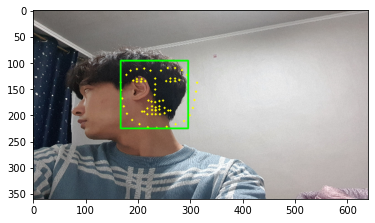

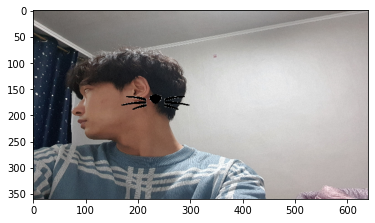

In [20]:
my_image_path_4 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image8.png'
img_bgr_4 = cv2.imread(my_image_path_4)    #- OpenCV로 이미지를 읽어서
img_bgr_4 = cv2.resize(img_bgr_4, (640, 360))    # 640x360의 크기로 Resize
img_show_4 = img_bgr_4.copy()      #- 출력용 이미지 별도 보관

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_4, point, 2, (0, 255, 255), -1) 
        
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_4, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_4 =  cv2.cvtColor(img_show_4, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_4)
plt.show()

img_show_rgb_4 = cv2.cvtColor(img_show_4, cv2.COLOR_BGR2RGB)
        
sticker_area = img_bgr_4[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr_4[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_4, cv2.COLOR_BGR2RGB))
plt.show()

# 마찬가지로 옆 모습에서 비박스가 인식하지 못하고 있습니다. 

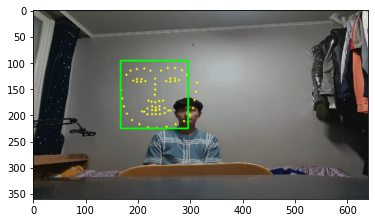

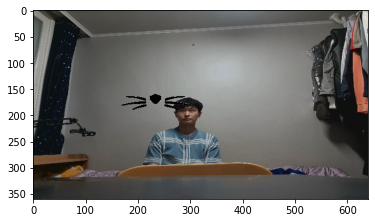

In [22]:
my_image_path_5 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image9.png'
img_bgr_5 = cv2.imread(my_image_path_5)    #- OpenCV로 이미지를 읽어서
img_bgr_5 = cv2.resize(img_bgr_5, (640, 360))    # 640x360의 크기로 Resize
img_show_5 = img_bgr_5.copy()      #- 출력용 이미지 별도 보관

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_5, point, 2, (0, 255, 255), -1) 
        
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_5, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_5 =  cv2.cvtColor(img_show_5, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_5)
plt.show()

img_show_rgb_5 = cv2.cvtColor(img_show_5, cv2.COLOR_BGR2RGB)
        
sticker_area = img_bgr_5[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr_5[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_5, cv2.COLOR_BGR2RGB))
plt.show()

# 얼굴이 작아도 인식을 못하고 있습니다.

# 회고
## 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
### 얼굴 각도에 따라 스티커도 같이 돌려주면 좋을 것 같습니다. 하지만 얼굴 각도가 많이 돌아가면 비박스가 인식을 제대로 하지 못하는 것을 확인 할 수 있었습니다.
## 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
### 여기서 사용한 얼굴 검출 방식은 일종의 템플릿 매칭입니다. 구글링을 해도 템플릿 이미지가 이미지보다 같거나 작아야 한다고만 있고 정확한 이유는 알 수 없었습니다. 
## 실행 속도가 중요할까요?
### 스티커 어플을 사용하는 입장에서 실행 속도는 중요하다고 생각합니다. 사용자가 사진혹은 동영상에 바로 스티커가 붙여져야 좋아할 것 같습니다.
## 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
### 어느 정도 정확하지 못 해도 재미로 넘어 갈 수 있겠지만 스탠다드한 사진조차 정확도가 떨어지면 안된다고 생각합니다.
### 처음에 스티커의 시작점을 찾고 그 위치를 이동하는데 시간을 많이 사용했다. 비박스의 크기마다 수염의 위치가 달아 졌기 때문인데, 이 문제로 고민하다 랜드마크의 점의 좌표로 이동시키면 좋다고 팀원의 도움을 받았다. 그래서 힌트에서 랜드마크의 좌표를 가지고 고민하라고 한것 같다.  